In [1]:
import pickle
import numpy as np
import copy
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest
import sys
import os

LOAD_FROM_PICKLE = False
USE_GPU = False

np.set_printoptions(precision=2, suppress=True)

In [2]:
if USE_GPU:
    import cupy as cp
    xp = cp
else:
    xp = np

In [3]:
df = pd.read_csv('../Data/Census/acs2017_census_tract_data.csv')
df = df.dropna()

df.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [4]:
# all but index 1 and 2
numeric_feature_labels = [0] + list(range(3, len(df.columns)))
catagorical_feature_labels = [1, 2]

In [5]:
le = LabelEncoder()
df['State'] = le.fit_transform(df['State'])
df['County'] = le.fit_transform(df['County'])

df.info()

data = df.values
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int64  
 2   County            72718 non-null  int64  
 3   TotalPop          72718 non-null  int64  
 4   Men               72718 non-null  int64  
 5   Women             72718 non-null  int64  
 6   Hispanic          72718 non-null  float64
 7   White             72718 non-null  float64
 8   Black             72718 non-null  float64
 9   Native            72718 non-null  float64
 10  Asian             72718 non-null  float64
 11  Pacific           72718 non-null  float64
 12  VotingAgeCitizen  72718 non-null  int64  
 13  Income            72718 non-null  float64
 14  IncomeErr         72718 non-null  float64
 15  IncomePerCap      72718 non-null  float64
 16  IncomePerCapErr   72718 non-null  float6

In [6]:
print(df['Poverty'].mean())
print(df['ChildPoverty'].mean())

16.046724332352376
21.148476305728984


In [7]:
# seperate child poverty rate from the rest of the data
y = df['ChildPoverty'].values
X = df.drop(['ChildPoverty'], axis=1).values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (72718, 36)
y shape: (72718,)


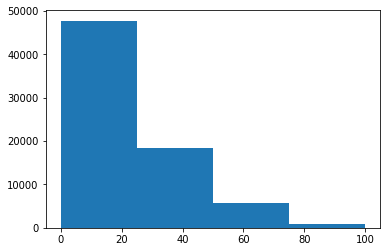

In [8]:
# graph a histogram of the child poverty rate
plt.hist(y, bins=4)
plt.show()

Quantiles:     [6.2, 16.3, 31.6]
Expert Ranges: [10.5, 21.1, 31.7]


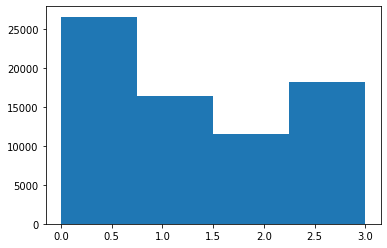

In [9]:
# test train split and balencing of the target variable

# equally divide y into 4 classes by q1, mean, and q3
q1 = np.quantile(y, 0.25)
q2 = np.quantile(y, 0.5)
q3 = np.quantile(y, 0.75)

quartiles = [q1, q2, q3]
expert_ranges = [10.5, 21.1, 31.7]

print(f"Quantiles:     {quartiles}")
print(f"Expert Ranges: {expert_ranges}")

y_q = np.digitize(y, quartiles)
y_e = np.digitize(y, expert_ranges)

# the quantile distribution should be evenly distributed

# graph the distribution of the classes in y_e
plt.hist(y_e, bins=4)
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_e, train_size=0.8, test_size=0.2, stratify=y_e)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(f"Bincount {np.bincount(y_train, minlength=4)}")
print(f"X shape: {X_train.shape}")
print(f"y shape: {y_train.shape}")

Bincount [21258 21258 21258 21258]
X shape: (85032, 36)
y shape: (85032,)


In [11]:
class TwoLayerPerceptronVectorized(object):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''

        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 
        """

        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)

        return A1, Z1, A2, Z2, A3

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                self.W1 -= eta * grad1
                self.W2 -= eta * grad2

                # momentum calculations
                # rho_W1, rho_W2 = eta * grad1, eta * grad2
                # self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                # self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                # rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [49]:
class MultiLayerPerceptron(object):
    def __init__(self, layers=2, n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.layers = layers
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        W = []
        b = []

        # create weights for input layer x hidden layer
        init_bound = 4*np.sqrt(6.0 / (self.n_hidden[0] + self.n_features_ + 1))
        W.append(np.random.uniform(-init_bound, init_bound, (self.n_hidden[0], self.n_features_)))
        b.append(np.zeros(self.n_hidden[0]))

        # create weights for all hidden layer x hidden layer
        for i in range(0, self.layers - 2):
            init_bound = 4*np.sqrt(6.0 / (self.n_hidden[i] + self.n_hidden[i+1] + 1))
            W.append(np.random.uniform(-init_bound, init_bound, (self.n_hidden[i], self.n_hidden[i + 1])))

        # create weights for hidden layer x output layer
        init_bound = 4*np.sqrt(6.0 / (self.n_hidden[-1] + self.n_output_ + 1))
        W.append(np.random.uniform(-init_bound, init_bound, (self.n_output_, self.n_hidden[-1])))

        # set the bias weights to zero
        for w in W:
            w[:, :1] = 0.0
            print(f"W.shape: {w.shape}")
            
        return W
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        L2s = 0.0
        for w in W:
            L2s += np.mean(w[:, 1:] ** 2)

        return (lambda_) * np.sqrt(L2s)
    
    def _cost(self, output, Y_enc, W):
        '''Get the objective function value'''

        cost = -np.mean(np.nan_to_num((Y_enc*np.log(output)+(1-Y_enc)*np.log(1-output))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W):
        """
        Compute feedforward step
        -----------
        X : Input layer with original features.
        W : List of weight matrices; W[layer] represents the weights connecting layer and layer + 1.
        ----------
        A : activations into layer (or output layer)
        Z : layer inputs 

        """

        A = []
        Z = []

        A.append(self._add_bias_unit(X, how='column'))
        A[0] = A[0].T
        Z.append(W[0] @ A[0])

        for i in range(1, self.layers):
            A.append(self._sigmoid(Z[i - 1]))
            A[i] = self._add_bias_unit(A[i], how='row')
            Z.append(W[i] @ A[i])

        A.append(self._sigmoid(Z[-1]))

        return A, Z

    def _get_gradient(self, A, Z, Y_enc, W):
        """Compute gradient step using backpropagation."""

        V = [None] * self.layers
        V[-1] = (A[-1] - Y_enc)

        for i in range(2, self.layers + 1):
            print(f"i: {i}")
            temp = W[-i + 1].T @ V[-i + 1]
            V[-i] = A[-i] * (1 - A[-i]) * temp

        grad = [None] * self.layers

        grad[-1] = V[-1] @ A[-2].T

        for i in range(self.layers - 1):
            grad[i] = V[i][1:, :] @ A[i].T
            grad[i][:, 1:] += W[i][:, 1:] * self.l2_C

        return grad
    
    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        # rho_W1_prev = np.zeros(self.W1.shape)
        # rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1) % print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A[-1], Y_enc[:, idx], self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A, Z, Y_enc[:, idx], self.W) 

                for i in range(self.layers - 1):
                    self.W[i] -= eta * grad[i]

                # momentum calculations
                # rho_W1, rho_W2 = eta * grad1, eta * grad2
                # self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                # self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                # rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [13]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

In [14]:
vals =        { 'n_hidden':30, 
                'C':0.1, 'epochs':30, 'eta':0.001, 
                'alpha':0.001, 'decrease_const':1e-5, 'minibatches':len(X_train)/32,
                'shuffle':True,'random_state':1}

vals_multi =  { 'layers':2, 'n_hidden':[30], 
                'C':0.1, 'epochs':30, 'eta':0.001, 
                'alpha':0.001, 'decrease_const':1e-5, 'minibatches':len(X_train)/32,
                'shuffle':True,'random_state':1}

Epoch: 30/30

Cross Entropy Loss :
Resubstitution acc: 0.25
Validation acc: 0.15903465346534654


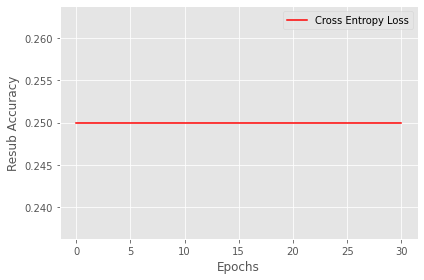

In [15]:
nn = TwoLayerPerceptronVectorized(**vals)
    
nn.fit(X_train, y_train, print_progress=1)

print_result(nn,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")

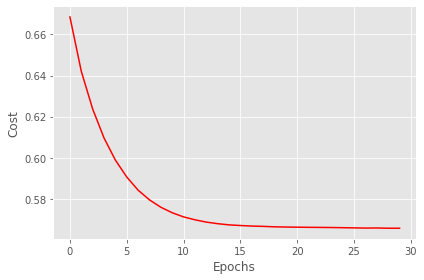

In [16]:
cost_avgs = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [17]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_feature_labels])
X_train[numeric_feature_labels] = scaler.transform(X_train[numeric_feature_labels])

# apply the same transformation to the test data
X_test[numeric_feature_labels] = scaler.transform(X_test[numeric_feature_labels])


Epoch: 30/30

Cross Entropy Loss :
Resubstitution acc: 0.25007056167090036
Validation acc: 0.15958470847084708


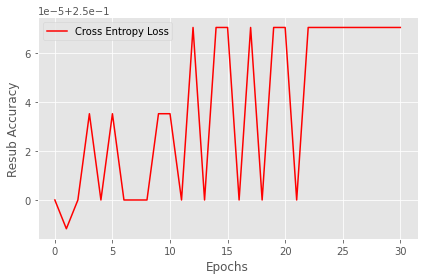

In [18]:
nn = TwoLayerPerceptronVectorized(**vals)
    
nn.fit(X_train, y_train, print_progress=1)

print_result(nn,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")

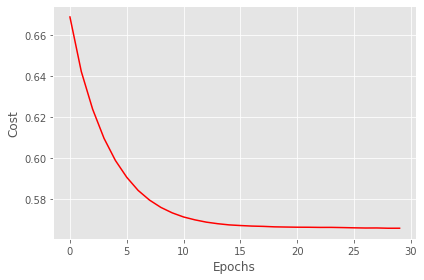

In [19]:
cost_avgs = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [20]:
# normalize the data
# X[:, 3:] = (X[:, 3:] - X[:, 3:].min(axis=0)) / (X[:, 3:].max(axis=0) - X[:, 3:].min(axis=0) + 1e-8)
# X[:, 0] = (X[:, 0] - X[:, 0].min(axis=0)) / (X[:, 0].max(axis=0) - X[:, 0].min(axis=0) + 1e-8)

# one hot encode state and county
states = pd.get_dummies(X[:, 1]).values
# not included becasue my computer doesnt have enough memory
# counties = pd.get_dummies(X[:, 2]).values

# print number of unique counties
print(len(np.unique(X[:, 2])))

print(states.shape)
# print(counties.shape)
print(X[:, 0:1].shape)
print(X[:, 3:].shape)

X = np.concatenate((X[:, 0:1], states, X[:, 3:]), axis=1)

1954
(72718, 52)
(72718, 1)
(72718, 33)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_e, train_size=0.8, test_size=0.2, stratify=y_e)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(f"Bincount {np.bincount(y_train, minlength=4)}")
print(f"X shape: {X_train.shape}")
print(f"y shape: {y_train.shape}")

Bincount [21258 21258 21258 21258]
X shape: (85032, 86)
y shape: (85032,)


In [22]:
scaler = StandardScaler()
# now that states and counties are one hot encoded, we can scale all of the data at once
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# apply the same transformation to the test data
X_test = scaler.transform(X_test)

Epoch: 30/30

Cross Entropy Loss :
Resubstitution acc: 0.7167066516135102
Validation acc: 0.7216034103410341


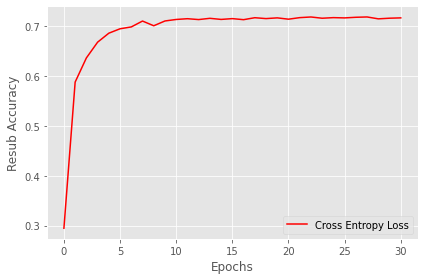

In [23]:
nn = TwoLayerPerceptronVectorized(**vals)
    
nn.fit(X_train, y_train, print_progress=1)

print_result(nn,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")

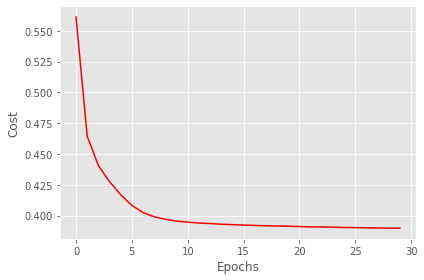

In [24]:
cost_avgs = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Epoch: 30/30

Cross Entropy Loss :
Resubstitution acc: 0.7057460720669866
Validation acc: 0.7120462046204621


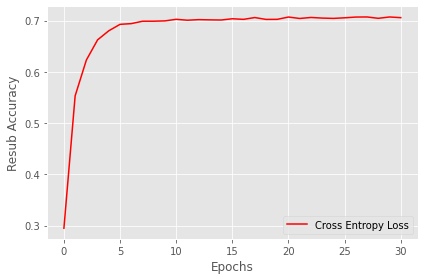

In [25]:
nn = MultiLayerPerceptron(**vals_multi)

nn.fit(X_train, y_train, print_progress=1)

print_result(nn,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")

In [50]:
vals_multi =  { 'layers':3, 'n_hidden':[30, 30, 30], 
                'C':0.1, 'epochs':30, 'eta':0.001, 
                'alpha':0.001, 'decrease_const':1e-5, 'minibatches':len(X_train)/32,
                'shuffle':True,'random_state':1}

nn = MultiLayerPerceptron(**vals_multi)

nn.fit(X_train, y_train, print_progress=1)

print_result(nn,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")

W.shape: (30, 87)
W.shape: (31, 30)
W.shape: (4, 31)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 31 is different from 30)